In [1347]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from linearmodels.panel import PanelOLS
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use('seaborn')

In [1251]:
# Import data for income group categorization
low_inc = pd.read_csv('low_inc.csv')
lower_mid_inc = pd.read_csv('lower_mid_inc.csv')
upper_mid_inc = pd.read_csv('upper_mid_inc.csv')
high_inc = pd.read_csv('high_inc.csv')

low_inc=low_inc['Country Name'].tolist()[:-5] + ['lower_inc']
lower_mid_inc = lower_mid_inc['Country Name'].tolist()[:-5] + ['lower_mid_inc']
upper_mid_inc = upper_mid_inc['Country Name'].tolist()[:-5] + ['upper_mid_inc']
high_inc = high_inc['Country Name'].tolist()[:-5] + ['high_inc']

In [1269]:
# Cleaning and reshaping ICT data
ICT = pd.read_csv('/Users/chenruoyu/Desktop/DB project data/ICT.csv')

ICT=ICT.rename(columns={'2004 [YR2004]':2004,'2005 [YR2005]':2005,'2006 [YR2006]':2006,'2007 [YR2007]':2007,'2008 [YR2008]':2008,\
                        '2009 [YR2009]':2009,'2010 [YR2010]':2010,'2011 [YR2011]':2011,'2012 [YR2012]':2012,\
                        '2013 [YR2013]':2013,'2014 [YR2014]':2014,'2015 [YR2015]':2015,\
                        '2016 [YR2016]':2016,'2017 [YR2017]':2017,'2018 [YR2018]':2018})
    
for i in ICT.columns[4:]:
    ICT[i]=pd.to_numeric(ICT[i],errors='coerce')
    
ICT.drop(['Country Code','Series Code'],axis=1, inplace=True)
ICT.drop(ICT.index[-195:],inplace=True)

In [1270]:
ICT.set_index(['Country Name', 'Series Name'],inplace=True)
ICT.columns.rename('year',inplace=True)
ICT=ICT.stack().swaplevel(1,2).unstack()

In [1273]:
ICT=ICT.dropna()
ICT['Secure Internet servers (per 1 million people)']=np.log(ICT['Secure Internet servers (per 1 million people)']+1)

In [1274]:
for i in [low_inc, lower_mid_inc, upper_mid_inc, high_inc]:
    ICT.loc[ICT.index.get_level_values('Country Name').isin(i),'inc_group']=i[-1]

In [1275]:
# Cleaning and reshaping governance indicators data
WGI = pd.read_csv('/Users/chenruoyu/Desktop/DB project data/WGI2.csv')

WGI=WGI.rename(columns={'2004 [YR2004]':2004,'2005 [YR2005]':2005,'2006 [YR2006]':2006,'2007 [YR2007]':2007,'2008 [YR2008]':2008,
                        '2009 [YR2009]':2009,'2010 [YR2010]':2010,'2011 [YR2011]':2011,'2012 [YR2012]':2012,
                        '2013 [YR2013]':2013,'2014 [YR2014]':2014,'2015 [YR2015]':2015,
                        '2016 [YR2016]':2016,'2017 [YR2017]':2017,'2018 [YR2018]':2018})
for i in WGI.columns[4:]:
    WGI[i]=pd.to_numeric(WGI[i],errors='coerce')

WGI=WGI.drop(['Country Code','Series Code'],axis=1)
WGI=WGI.set_index(['Country Name','Series Name'])
WGI.columns.rename('year',inplace=True)
WGI=WGI.stack().swaplevel(1,2).unstack()

In [1276]:
# Merging ICT and WGI data
ICT.index.rename(['country_name','time'],inplace=True)
WGI_ICT=WGI.merge(ICT, how='left', left_index=True, right_on=['country_name','time'])
WGI_ICT = WGI_ICT.swaplevel(0,1)

In [1277]:
# New dataframe for the cleaned data
df=WGI_ICT.dropna()

In [1278]:
df=df.rename(columns={'Control of Corruption: Estimate':'corruption','Government Effectiveness: Estimate':'effectiveness',
                  'Political Stability and Absence of Violence/Terrorism: Estimate':'stability','Regulatory Quality: Estimate':'regulation',
                  'Rule of Law: Estimate':'law','Voice and Accountability: Estimate':'voice','Fixed broadband subscriptions (per 100 people)':'broadband',
                  'ICT service exports (BoP, current US$)':'export','Individuals using the Internet (% of population)':'user',
                  'Mobile cellular subscriptions (per 100 people)':'mobile','Secure Internet servers (per 1 million people)':'server'})

In [1279]:
df

,Series Name,corruption,effectiveness,stability,regulation,law,voice,broadband,user,mobile,server,inc_group
time,country_name,,,,,,,,,,,
2010,Afghanistan,-1.635723,-1.454683,-2.579152,-1.532861,-1.845436,-1.404468,0.005140,4.000000,35.003127,0.391833,lower_inc
2012,Afghanistan,-1.419888,-1.360140,-2.418561,-1.193118,-1.643165,-1.267430,0.004814,5.454545,49.227977,0.797263,lower_inc
2013,Afghanistan,-1.436761,-1.384930,-2.519349,-1.193137,-1.597314,-1.240068,0.004648,5.900000,52.083576,0.886034,lower_inc
2014,Afghanistan,-1.354784,-1.331396,-2.411068,-1.118182,-1.445648,-1.135445,0.004495,7.000000,55.159515,0.996240,lower_inc
2015,Afghanistan,-1.341994,-1.322968,-2.571222,-0.997371,-1.504040,-1.117563,0.020535,8.260000,57.271068,1.147502,lower_inc
...,...,...,...,...,...,...,...,...,...,...,...,...
2014,Zambia,-0.342243,-0.499575,0.156212,-0.503428,-0.236549,-0.109601,0.133255,19.000000,65.681859,1.627469,lower_mid_inc
2015,Zambia,-0.341261,-0.555665,0.151695,-0.436516,-0.229715,-0.066545,0.147298,21.000000,72.784572,1.897280,lower_mid_inc
2016,Zambia,-0.401866,-0.660059,0.142808,-0.483593,-0.300440,-0.306110,0.194238,25.506579,73.438230,2.288606,lower_mid_inc


# Correlation visualization

In [1280]:
df

,Series Name,corruption,effectiveness,stability,regulation,law,voice,broadband,user,mobile,server,inc_group
time,country_name,,,,,,,,,,,
2010,Afghanistan,-1.635723,-1.454683,-2.579152,-1.532861,-1.845436,-1.404468,0.005140,4.000000,35.003127,0.391833,lower_inc
2012,Afghanistan,-1.419888,-1.360140,-2.418561,-1.193118,-1.643165,-1.267430,0.004814,5.454545,49.227977,0.797263,lower_inc
2013,Afghanistan,-1.436761,-1.384930,-2.519349,-1.193137,-1.597314,-1.240068,0.004648,5.900000,52.083576,0.886034,lower_inc
2014,Afghanistan,-1.354784,-1.331396,-2.411068,-1.118182,-1.445648,-1.135445,0.004495,7.000000,55.159515,0.996240,lower_inc
2015,Afghanistan,-1.341994,-1.322968,-2.571222,-0.997371,-1.504040,-1.117563,0.020535,8.260000,57.271068,1.147502,lower_inc
...,...,...,...,...,...,...,...,...,...,...,...,...
2014,Zambia,-0.342243,-0.499575,0.156212,-0.503428,-0.236549,-0.109601,0.133255,19.000000,65.681859,1.627469,lower_mid_inc
2015,Zambia,-0.341261,-0.555665,0.151695,-0.436516,-0.229715,-0.066545,0.147298,21.000000,72.784572,1.897280,lower_mid_inc
2016,Zambia,-0.401866,-0.660059,0.142808,-0.483593,-0.300440,-0.306110,0.194238,25.506579,73.438230,2.288606,lower_mid_inc


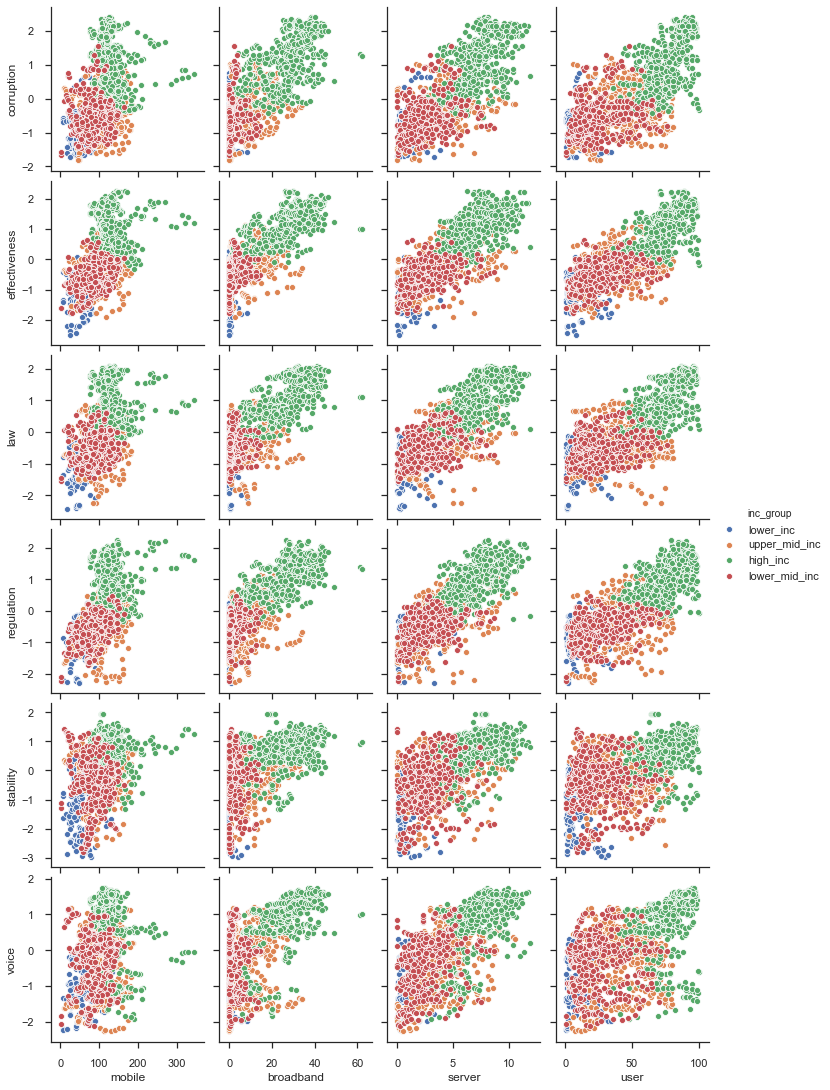

In [1282]:
sns.set(style="ticks")
sns.pairplot(df, x_vars=['mobile','broadband','server','user'],
             y_vars = ['corruption','effectiveness', 'law', 'regulation', 'stability', 'voice'],
            hue="inc_group")


# Regression analysis

In [1283]:
# Creating matrices for dependent and independent variables
y, X = dmatrices('corruption ~  broadband + mobile + user +server', data=df, return_type='dataframe')

In [1284]:
# Performing a pooled OLS
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x1a49304ed0>>


In [1285]:
# Reshaping the data to become panel data
df=df.swaplevel(0,1)

In [1286]:
# Importing, cleaning and shaping control variable data
controls = pd.read_csv('/Users/chenruoyu/Desktop/DB project data/controls.csv')

controls=controls.rename(columns={'2004 [YR2004]':2004,'2005 [YR2005]':2005,'2006 [YR2006]':2006,'2007 [YR2007]':2007,'2008 [YR2008]':2008,\
                        '2009 [YR2009]':2009,'2010 [YR2010]':2010,'2011 [YR2011]':2011,'2012 [YR2012]':2012,\
                        '2013 [YR2013]':2013,'2014 [YR2014]':2014,'2015 [YR2015]':2015,\
                        '2016 [YR2016]':2016,'2017 [YR2017]':2017,'2018 [YR2018]':2018})
    
for i in controls.columns[4:]:
    controls[i]=pd.to_numeric(controls[i],errors='coerce')
    
controls.drop(['Country Code','Series Code'],axis=1, inplace=True)

controls.set_index(['Country Name', 'Series Name'],inplace=True)
controls.columns.rename('year',inplace=True)
controls=controls.fillna(method='ffill',axis=1)
controls=controls.fillna(method='bfill',axis=1)
controls=controls.stack().swaplevel(1,2).unstack()
controls.drop(controls.index[-690:],inplace=True)
controls.index.rename(['country_name','time'],inplace=True)

In [1287]:
df=df.merge(controls, how='left', left_index=True, right_on=['country_name','time'])

In [1288]:
df.rename(columns={'Depositors with commercial banks (per 1,000 adults)':'depositors',
       'Firms using banks to finance investment (% of firms)':'fin_invest',
       'Firms using banks to finance working capital (% of firms)':'fin_working',
       'GDP per capita (current US$)':'GDP_pc',
       'Literacy rate, adult total (% of people ages 15 and above)':'literacy'},inplace=True)

In [1294]:
iterables = [['corruption', 'effectiveness', 'stability', 'regulation', 'law', 'voice'],
             ['mobile', 'broadband', 'user', 'server', 'depositors', 'fin_invest', 'GDP_pc', 'literacy']]
index = pd.MultiIndex.from_product(iterables, names=['eng', 'exog'])
reg_results = pd.DataFrame(columns=['params','p_value'], index=index)

In [1295]:
# Fixed effects with country on all governance indicators with additional control variables
engs = ['corruption', 'effectiveness', 'law', 'regulation', 'stability', 'voice']
exogs = ['mobile', 'broadband', 'user', 'server', 'depositors', 'fin_invest', 'GDP_pc', 'literacy']
for eng in engs:
    y, X = dmatrices( eng + '~  broadband + mobile + user + server + depositors + fin_invest + GDP_pc + literacy', data=df, return_type='dataframe')
    mod = PanelOLS(y, X, entity_effects=True)
    res = mod.fit(cov_type='robust')

    df[eng+'_hat'] = res.fitted_values
    df[eng+'_error'] = df[eng] - df[eng+'_hat']

    for i in res.params.index[1:]:
        reg_results.loc[(eng,i),'params']=res.params.loc[i]
        reg_results.loc[(eng,i),'p_value']=res.pvalues.loc[i]

for i in reg_results.columns:
    reg_results[i]=pd.to_numeric(reg_results[i])


Text(0.5, 1.0, 'voice')

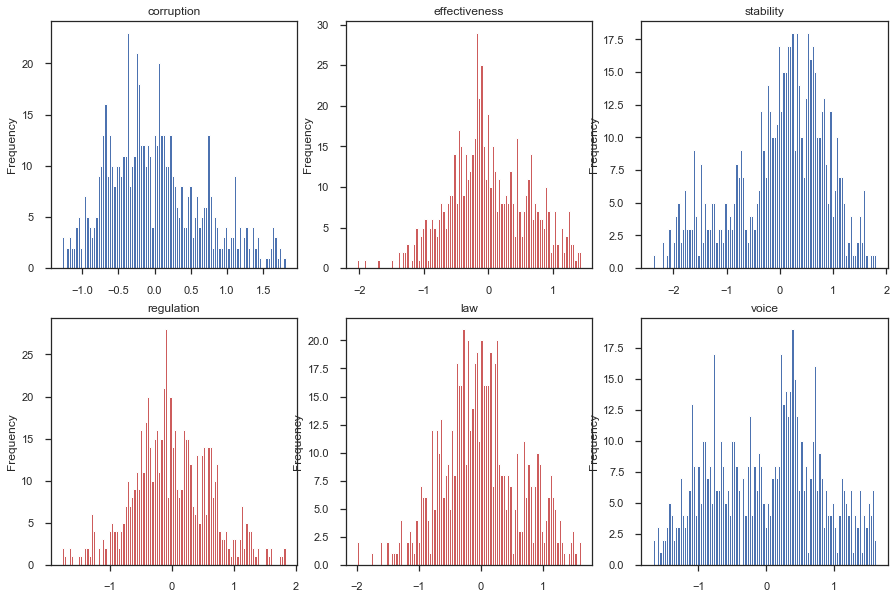

In [1297]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)
fig.set_size_inches(15,10)
df['corruption_error'].plot.hist(bins=100,ax=ax1)
df['effectiveness_error'].plot.hist(bins=100,ax=ax2, color = 'indianred')
df['stability_error'].plot.hist(bins=100,ax=ax3)
df['regulation_error'].plot.hist(bins=100,ax=ax4, color = 'indianred')
df['law_error'].plot.hist(bins=100,ax=ax5, color = 'indianred')
df['voice_error'].plot.hist(bins=100,ax=ax6)
ax1.set_title('corruption')
ax2.set_title('effectiveness')
ax3.set_title('stability')
ax4.set_title('regulation')
ax5.set_title('law')
ax6.set_title('voice')

In [1344]:
def heatmap(data, data2, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, size=1)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    
    # Change the color of the xtick labels to red for exogenous variables with (unexpected) negative coefficients...
    colors = ['red', 'crimson', 'indianred']
    ind=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data2.iloc[i,j]<0:
                ax.get_yticklabels()[i].set_color(colors[ind])
                ax.get_xticklabels()[j].set_color(colors[ind]) 
                ind+=1
                
    # ...and set italic style for endogenous variables associated with normally distributed errors in their regression. 
            if i==1 or i==2 or i==3:
                ax.get_yticklabels()[i].set_style('italic')

    return im, cbar



def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [1366]:
mpl.style.use('seaborn-poster')

reg_sig = reg_results.loc[reg_results['p_value']<=0.05]
params = pd.pivot_table(reg_sig, values='params', index=['eng'], columns=['exog'])
params=params.fillna(0)
params['broadband']=0
params['server']=0
params.loc['server',params.columns]=0
params = params[exogs]


p_value = pd.pivot_table(reg_results, values='p_value', index=['eng'], columns=['exog'])
p_value=p_value[exogs]

params=params.reindex(p_value.index.tolist())


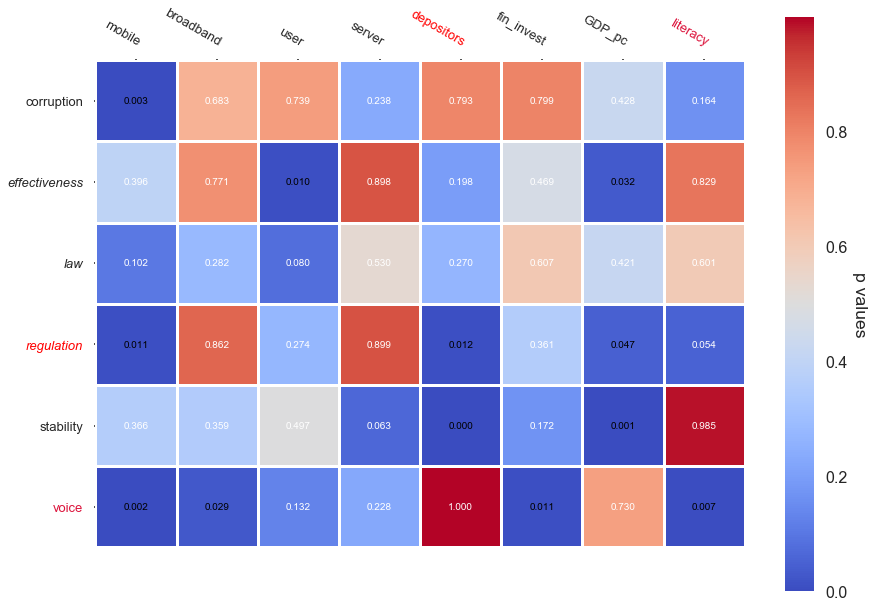

In [1367]:
fig, ax = plt.subplots()

im, cbar = heatmap(p_value, params, p_value.index.tolist(), p_value.columns.tolist(), ax=ax,
                   cmap="coolwarm", cbarlabel="p values")
texts = annotate_heatmap(im, valfmt="{x:.3f}", threshold = 0.05)

ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=13)


fig.tight_layout()
